In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [61]:
import os
import pickle
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.integrate as integrate
from scipy.interpolate import interpn, RegularGridInterpolator
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import tskit as tsk
import statsmodels.api as sm


from bgspy.utils import bin_chrom, bin_chroms
from bgspy.plots import get_figax

from bgspy.theory2 import Q2_asymptotic, Q2_sum_integral, Q2_sum_integral2
from bgspy.theory2 import ave_het, bgs_segment_sc16_vec, bgs_segment_sc16
from bgspy.theory2 import bgs_rec
from bgspy.theory2 import bgs_segment_sc16_parts
from bgspy.theory2 import Ne_t, Ne_asymp2, Ne_asymp
from bgspy.theory2 import Qr_asymp, Qr_asymp2
from bgspy.theory2 import Qr_fixed, Qr_fixed2
from bgspy.theory2 import Ne_t_full2

In [18]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [19]:
mpl.__version__

'3.6.2'

In [21]:
# fixed params from the sims
L = 100_000
N = 1_000
rbp = 1e-8

# Regional Simulations

## Diversity along the chromosome in region simulations

When comparing theory to simulations, we must be mindful that the theory is modeling the reduction *at the middle of the chromosome*. We can see why this is important by taking a subset of the tree sequences from simulations with the same parameters and looking at windowed average diversity: 

In [22]:
tree_dir = '../data/slim_sims/region/tree_subset/'
tree_files = os.listdir(tree_dir)

bins = bin_chrom(L, 1000)

pi = [tsk.load(os.path.join(tree_dir, f)).diversity(windows=bins, mode='branch') for f in tree_files]

Text(0.5, 0, 'position')

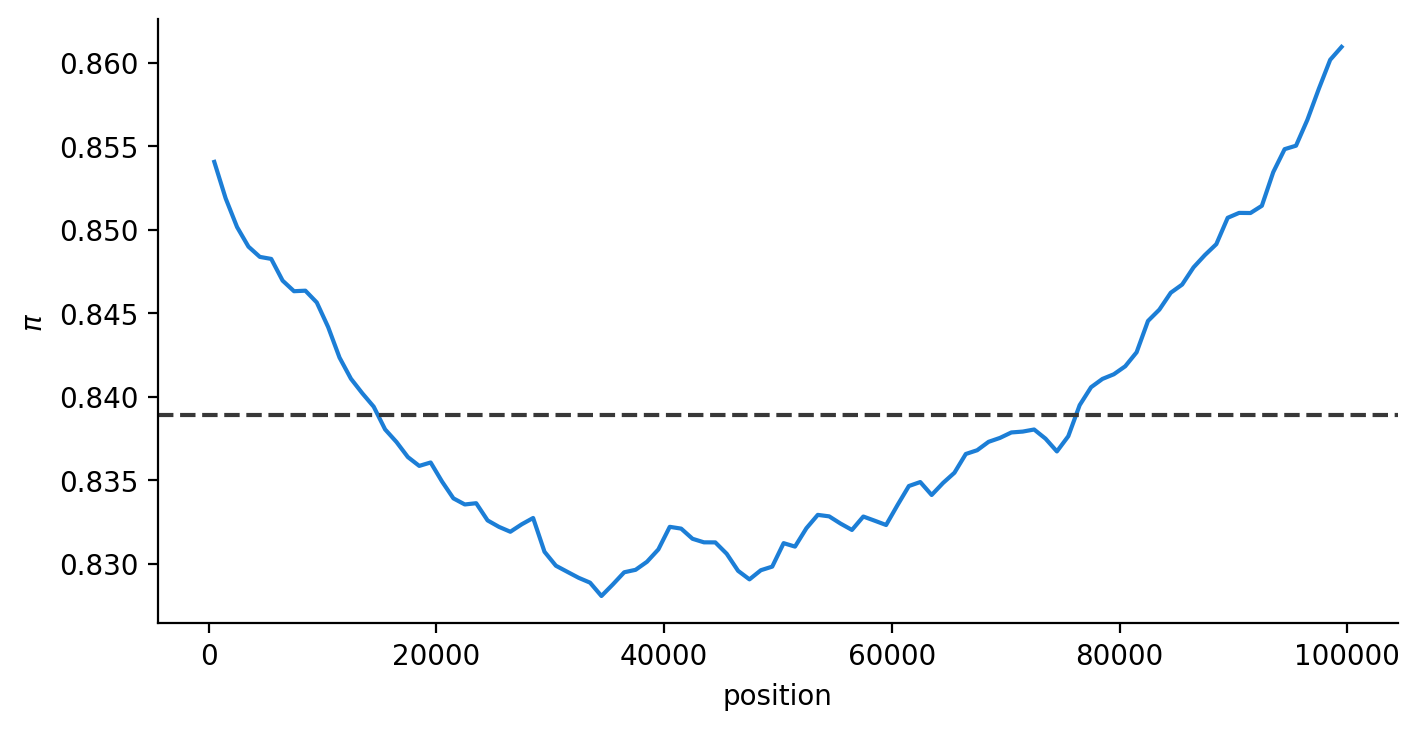

In [23]:
midpoints = (bins[1:] + bins[:-1])/2
plt.plot(midpoints, np.stack(pi).mean(axis=0)/(4*N))
plt.axhline(np.mean(pi)/(4*N), c='0.22', linestyle='dashed')
plt.ylabel("$\pi$")
plt.xlabel("position")

## Load in Simulation Results

Pre-processed by `tools/process_region_sims.py`.

NOTE: the ratchet estimates here in these data are wrong (and these take a while to run), so I correcth them below.

In [24]:
d = pd.read_pickle('../data/slim_sims/region/region_results.pkl')
d.head()

,generation,k_mean,k_sd,k3,k4,f_mean,f_sd,f3,f4,s,...,B_middle,ratchet,sh,N,rbp,mu,U,r2sum,ldsum,ldn
0,9991,5.672,2.164050,0.260849,47.444700,0.998209,0.000683,-7.906440e-12,4.702630e-13,2,...,0.698212,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000316,1000,1.000000e-08,1.000000e-08,0.001000,9.089089,0.433346,34
1,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,0.853508,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000010,1000,1.000000e-08,1.000000e-10,0.000010,0.000000,0.000000,0
2,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,0.769276,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000032,1000,1.000000e-08,3.160000e-10,0.000032,0.000000,0.000000,0
3,9991,0.001,0.031623,0.000997,0.000996,0.999900,0.003162,-9.970020e-07,9.960060e-08,0,...,1.156344,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.100000,1000,1.000000e-08,3.160000e-10,0.000032,0.000000,0.000000,0
4,9991,0.355,0.532220,0.170893,0.260478,0.999965,0.000053,-1.708930e-13,2.604780e-17,4,...,0.387827,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000100,1000,1.000000e-08,1.000000e-09,0.000100,0.000127,-0.000102,6


In [25]:
d.columns

Index(['generation', 'k_mean', 'k_sd', 'k3', 'k4', 'f_mean', 'f_sd', 'f3',
       'f4', 's', 'r', 'ssh', 'R', 'B', 'B_middle', 'ratchet', 'sh', 'N',
       'rbp', 'mu', 'U', 'r2sum', 'ldsum', 'ldn'],
      dtype='object')

### Ratchet Rate Correction

Note that the ratchet estimates by my processing program are biased, because I didn't trim off enough burnin. So I re-restimate those here (before the data is saved for supp data).

In [26]:
def average_ratchet_rates(d):
    data = dict()
    for mu in d['mu'].unique():
        for sh in d['sh'].unique():
            # get the ratchet values
            M = d.loc[(d['sh'] == sh) & (d['mu'] == mu)]['ratchet'].values
            D = np.stack([x for x in M]) 
            D_mean = D.mean(axis=0)
            data[(mu, sh)] = D_mean
    return data
    
def ratchet_rate_estimate(data, buffer=9000):
    rates = dict()
    for mu, sh in data.keys():
        d = data[(mu, sh)]
        if buffer is not None:
            d = d[d[:, 0] > buffer, :]
        X = sm.add_constant(d[:, 0])
        y = d[:, 1]
        fit = sm.OLS(y, X).fit()
        R = fit.params[1]
        rates[(mu, sh)] = R
    return rates
    

rate_data = average_ratchet_rates(d)
rates = ratchet_rate_estimate(rate_data)

In [27]:
# let's make a friendlier dataframe of these data

rows = []
for key in rate_data.keys():
    mu, sh = key
    for row in rate_data[key]:
        rows.append(dict(mu=mu, sh=sh, generation=row[0], fixations=row[1], rate=rates[key]))
ratchet_df = pd.DataFrame(rows)


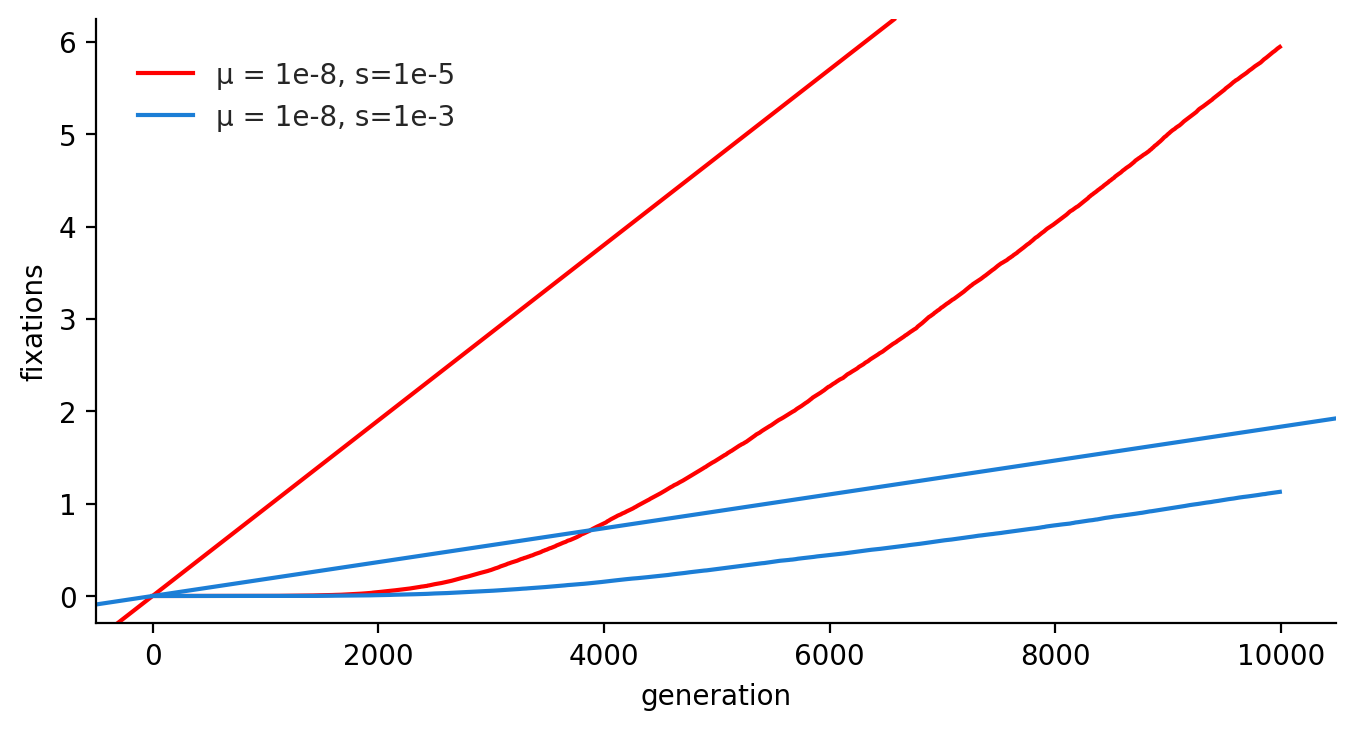

In [28]:
plt.plot(*rate_data[(1e-8, 1e-5)].T, c='r', label='μ = 1e-8, s=1e-5')
plt.axline((0, 0), slope=rates[(1e-8, 1e-5)], c='r')
plt.plot(*rate_data[(1e-8, 1e-3)].T, label='μ = 1e-8, s=1e-3')
plt.axline((0, 0), slope=rates[(1e-8, 1e-3)])
plt.ylabel('fixations')
plt.xlabel('generation')
plt.legend()

### Save Supplementary Data

In [29]:
# let's make a friendly version of the data for saving to TSV
df = d.loc[:, ~d.columns.isin(['ratchet', 'R'])]
df.to_csv('../data/supplementary_data/simulation_data.tsv.gz', sep='\t', index=False)

# save the ratchet data
ratchet_df.to_csv('../data/supplementary_data/simulation_ratchet_data.tsv.gz', sep='\t', index=False)

In [30]:
# average across replicates
dg = d.groupby(['sh', 'rbp', 'N', 'mu', 'U']).mean().reset_index()

In [31]:
dg['sh'].unique(), dg['mu'].unique(), dg['rbp'].unique()

(array([1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04, 1.00e-03, 3.16e-03,
        1.00e-02, 3.16e-02, 1.00e-01]),
 array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]),
 array([1.e-08]))

# Comparing Simulations to Theory

Pre-compute all the theory data, for the regional simulations.

In [32]:
theory_data = dict()

x = np.logspace(-5, 1, 100)
for mu in dg['mu'].unique():
    # NOTE: we need asymptotic = False so that *everything* is computed (which is more expensive)
    parts = np.array(bgs_segment_sc16_parts(mu, x, L, rbp, N, asymptotic=False))
    Bs = np.array([x[0] for x in parts])
    Bs_asymp = np.array([x[1] for x in parts])
    other_stuff = [x[5:] for x in parts]
    classic_bgs = np.array([x[-1] for x in parts])
    Vs = np.array([x[3] for x in parts])
    Vms = np.array([x[4] for x in parts])    
    Ts = np.array([x[2] for x in parts])
    theory_data[mu] = x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff
    

/home/vsb/projects/bprime/bgspy/theory2.py:93: RuntimeWarning: overflow encountered in exp
  out = (np.exp(4*sh*Ne) - 1)/(2*U*sh*Ne)
/home/vsb/projects/bprime/bgspy/theory2.py:307: RuntimeWarning: invalid value encountered in double_scalars
  return [np.log(new_T) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory2.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrand = quad(lambda r: ((1-(1-r)**(T+1) * Z**(T+1))/(1 - (1-r)*Z))**2, 0, M/2)[0]
/home/vsb/projects/bprime/bgspy/theory2.py:123: RuntimeWarning: overflow encountered in double_scalars
  integrand = quad(lambda 

In [33]:
with open('../data/supplementary_data/region_theory_data.pkl', 'wb') as f:
    pickle.dump(theory_data, f)

(0.0015, 100)


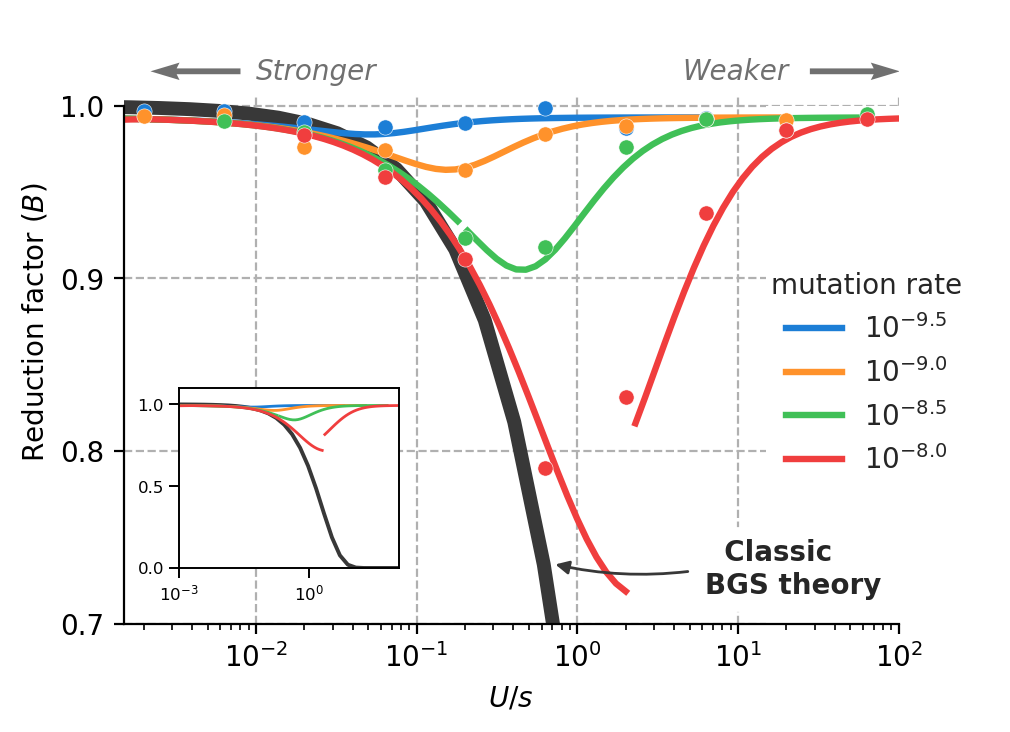

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def B_theory_plot(sim_dg, L, rbp, N, mus=None, x=np.logspace(-5, np.log10(0.9), 50), 
                  include_asymp=True, labels=True, xlim=None, ylim=None, 
                  marker_size=5, linewidth=2, data=None,
                  bgs_linewidth=2, bgs_zorder=10, figax=None, **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    if mus is None:
        mus = sim_dg['mu'].unique()
    for mu in mus:
        dgs = sim_dg.loc[dg['mu'] == mu]

        U = 2*mu*L
        mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
        
        # sim data
        sh = dgs['sh'].values
        rate = U/sh
        col = next(ax._get_lines.prop_cycler)['color']
        ax.scatter(rate, dgs['B_middle'], edgecolor='white', linewidth=0.2, c=col, s=marker_size, zorder=10)

        # theory part
        if data is None:
            # calculate the values directly
            Bs_asymp = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False))
            Bs = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False, asymptotic=False, sum_n=10))
        else:
            # use pre-calc'd dict
            x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff = data[mu]
        #Bs = np.array(bgs_segment_sc162(mu, x2, L, rbp, 1000, asymptotic=False, sum_n=10))
        #plt.plot(U/x, Bs_asymp, label=mu)

        if include_asymp:
            ax.plot(U/x, Bs_asymp, c=col, linestyle='dashed', linewidth=linewidth)
        #ax.plot(U/x, Bs, c=col, linewidth=linewidth, label=mu_label)
        ax.plot(U/x[~classic_bgs], Bs[~classic_bgs], c=col, linewidth=linewidth, label=mu_label)
        #ax.plot(U/x[classic_bgs], Bs[classic_bgs], c=col, linestyle=(0, (7, 2)), linewidth=linewidth)
        ax.plot(U/x[classic_bgs], Bs[classic_bgs], c=col, linewidth=linewidth)
    mu = max(mus)
    mu_x = np.logspace(-8, 1, 50)
    bgs_theory = bgs_rec(mu, mu_x, L, rbp)
    ax.plot(2*mu*L/mu_x, bgs_theory, c='0.22', linewidth=bgs_linewidth, zorder=bgs_zorder)
    
    ax.semilogx()
    if labels:
        ax.set_ylabel("B")
        ax.set_xlabel("U/s")
    if ylim is not None:
        ax.set_ylim(*ylim)
    if xlim is not None:
        print(xlim)
        ax.set_xlim(*xlim)
    else:
        ax.set_xlim(1e-3, 120)
    return fig, ax
    

plt.rcParams['text.usetex'] = False

    
fig, ax = plt.subplots(figsize=(5, 4))

axin = inset_axes(ax, width=1.1, height=0.9, loc=3, borderpad=2)

MUs = [3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]

## MAIN CALLS
B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, ax), data=theory_data,
              xlim=(0.0015, 100), include_asymp=False,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.05), 
              marker_size=30, bgs_zorder=1,
              legend=True, bgs_linewidth=5, linewidth=2.3)
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)

for item in ([axin.title, axin.xaxis.label, axin.yaxis.label] +
              axin.get_xticklabels() + axin.get_yticklabels()):
    item.set_fontsize(6)

axin.tick_params(axis="y", direction="out", pad=2)
axin.tick_params(axis="x", direction="out", pad=2)
axin_axeswidth = 0.7
for spine in ['top', 'right', 'left', 'bottom']:
    axin.spines[spine].set_visible(True)
    axin.spines[spine].set_linewidth(axin_axeswidth)
axin.xaxis.set_tick_params(width=axin_axeswidth)
axin.yaxis.set_tick_params(width=axin_axeswidth)
    
# draw the box around zoomed-in region
draw_box = False
if draw_box:
    x, y = ax.axes.get_xlim(), ax.axes.get_ylim()
    zoom = mpl.patches.Rectangle((x[0], y[0]), x[1] - x[0], y[1] - y[0], 
                                 linewidth=0.1, edgecolor='0.22', facecolor='none')
    axin.add_patch(zoom)

#ax.axhline(1, linestyle='dashed', c='0.22', linewidth=1, zorder=-1)
#axin.axhline(1, linestyle='dashed', c='0.22', linewidth=0.5, zorder=-1)

leg = ax.legend(loc=(0.8, 0.2), fontsize=10, title="mutation rate", framealpha=1, facecolor='white')
frame = leg.get_frame()
frame.set_facecolor('blue')
ax.text(0.01, 1.015, "Stronger", c='0.44', style='italic')
ax.quiver(0.008, 1.02, -0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.text(4.5, 1.015, "Weaker",  c='0.44', style='italic')
ax.quiver(28, 1.02, 0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.annotate("  Classic\nBGS theory", xy=(0.55, 0.1), xytext=(0.75, 0.05), 
            backgroundcolor='white', 
             arrowprops=dict(arrowstyle="-|>", color='0.22', relpos=(0., 0.5),
                            connectionstyle="arc3,rad=-0.1"),
            xycoords=ax.transAxes, weight=550)

ax.set_ylabel("Reduction factor ($B$)")
ax.set_xlabel("$U/s$")
ax.spines['left'].set_bounds((0.7, 1))
ax.grid(linestyle='dashed')
ax.set_axisbelow(True)
#axin.annotate("  Classic\nBGS theory", xy=(0.05, 0.1), fontsize=5)
ax.set_yticks([0.7, 0.8, 0.9, 1])

# mask the grid behind arrows
mask_grid_quiver = mpl.patches.Rectangle((0, 1.005), 100, 0.1, facecolor='white', zorder=1)
ax.add_patch(mask_grid_quiver)

# mask grid behind legend
mask_grid = mpl.patches.Rectangle((15, 0.2), 400, 0.8, facecolor='white', zorder=1)
ax.add_patch(mask_grid)

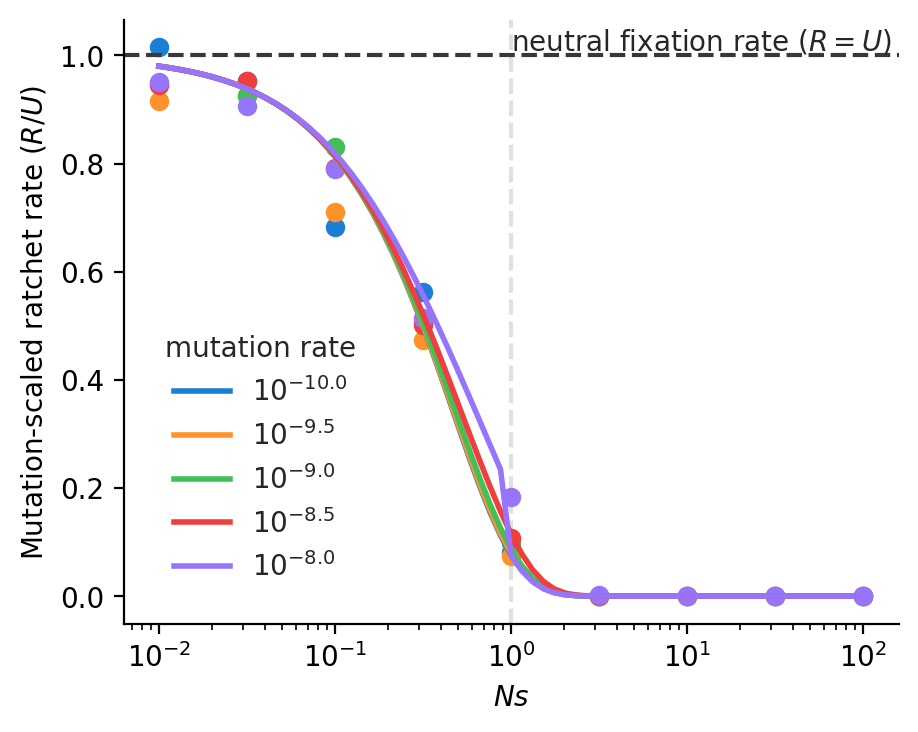

In [35]:
max_T = 100000

fig, ax = plt.subplots(figsize=(5, 4))

for mu in theory_data.keys():
    mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
    dgs = dg.loc[dg['mu'] == mu]
    U = 2*mu*L
    s = theory_data[mu][0]
    sN = s*N
    T = theory_data[mu][4]
    R = 2/(T*U)
    col = next(ax._get_lines.prop_cycler)['color']
    keep = sN < 1e2
    ax.plot(N*s[keep], R[keep], c=col, alpha=1, linewidth=2, label=mu_label)
    
    R_est = np.array([rates[(mu, sh)] for sh in dgs['sh']])
    ax.scatter(dgs['sh']*N, 2*R_est/U, c=col)
ax.set_ylabel("Mutation-scaled ratchet rate ($R/U$)")
ax.set_xlabel("$Ns$")

fig.canvas.draw()
ax.legend(title="mutation rate")
ax.axhline(1, linestyle='dashed', c='0.22')
ax.annotate("neutral fixation rate ($R = U$)", (1, 1.01), xycoords='data')
ax.set_xscale('log')
ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')



/tmp/ipykernel_67551/152804475.py:38: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(1e-7, 0)


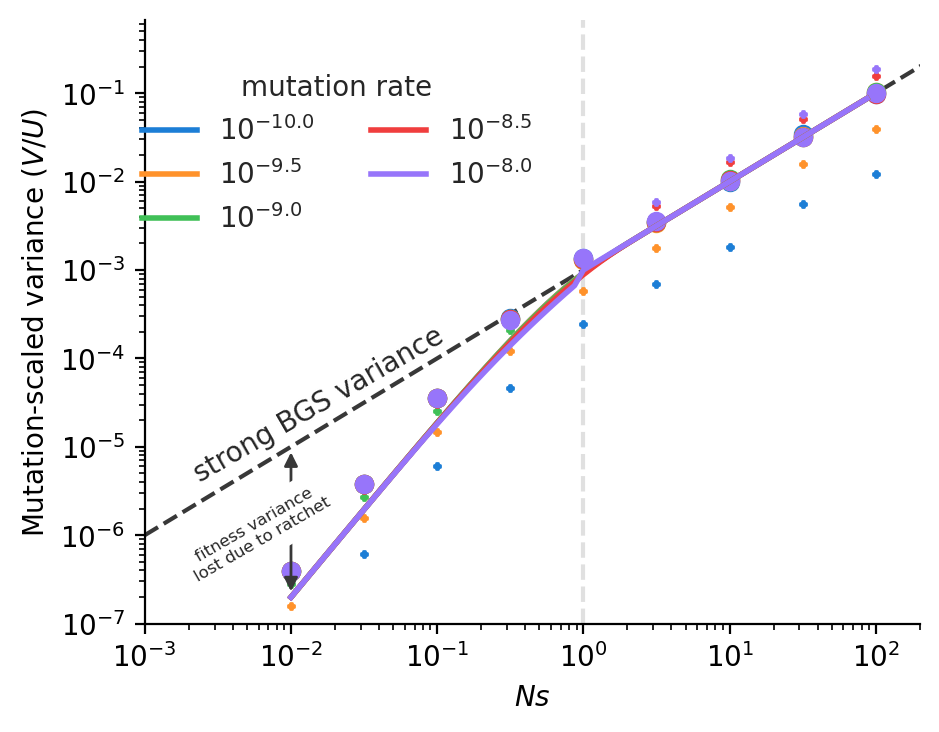

In [36]:
max_T = 100000

fig, ax = plt.subplots(figsize=(5, 4))

for mu in theory_data.keys():
    mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
    U = 2*mu*L
    sN = theory_data[mu][0] * N
    T = theory_data[mu][4]
    V = theory_data[mu][3] / U
    R =  1/T
    
    keep = sN < 1e2
    col = next(ax._get_lines.prop_cycler)['color']
    ax.plot(sN[keep], V[keep], linewidth=2,  label=mu_label, c=col)

    # new theory
    #ax.plot(sN, V, c=lines[0].get_color(), alpha=1, linewidth=2, label=mu_label)
    dgs = dg.loc[dg['mu'] == mu]
    # full fitness, including LD
    VA = dgs['f_sd']**2
    # genic fitness. k_mean is average of COUNT of mutations per diploid individual.
    Vf = dgs['sh']**2 * dgs['k_mean'] / 2
    ax.scatter(dgs['sh'] * N, Vf / (dgs['U']), c=col)
    ax.scatter(dgs['sh'] * N, VA / (dgs['U']), c=col, marker='P', s=4)
xs = np.logspace(-6, -0.5, 100)

ax.plot(xs*N, xs, zorder=-10, linestyle='dashed', c='0.22')
ax.annotate("strong BGS variance", (2e-3, 4e-6), xycoords='data', rotation=30)
ax.set_ylabel("Mutation-scaled variance ($V/U$)")
ax.set_xlabel("$Ns$")

ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')
fig.canvas.draw()
ax.legend(loc=(-0.04, 0.6), fontsize=10, ncol=2, title="mutation rate")
ax.loglog()
ax.set_xlim(1e-3, 2e2)
ax.set_ylim(1e-7, 0)
ax.annotate("$Ns = 1$", (1.1, 5e-8), xycoords='data', weight=550)
ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7),
            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>'))
ax.annotate("fitness variance\nlost due to ratchet", (6e-3, 3e-7), horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
            fontsize=6, rotation=30)

# ax.annotate("fitness variance\nlost due to ratchet", (8e-3, 1e-6), horizontalalignment='center',
#             bbox=dict(facecolor='white', alpha=1, linewidth=0), 
#             fontsize=4, rotation=0)



## Figure 1

In [37]:
# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

In [59]:
# load in subfigure D data
with open('../data/supplementary_data/figure_1_bmap_data.pkl', 'rb') as f:
    sibfigc_data = pickle.load(f)

(0.0015, 100)


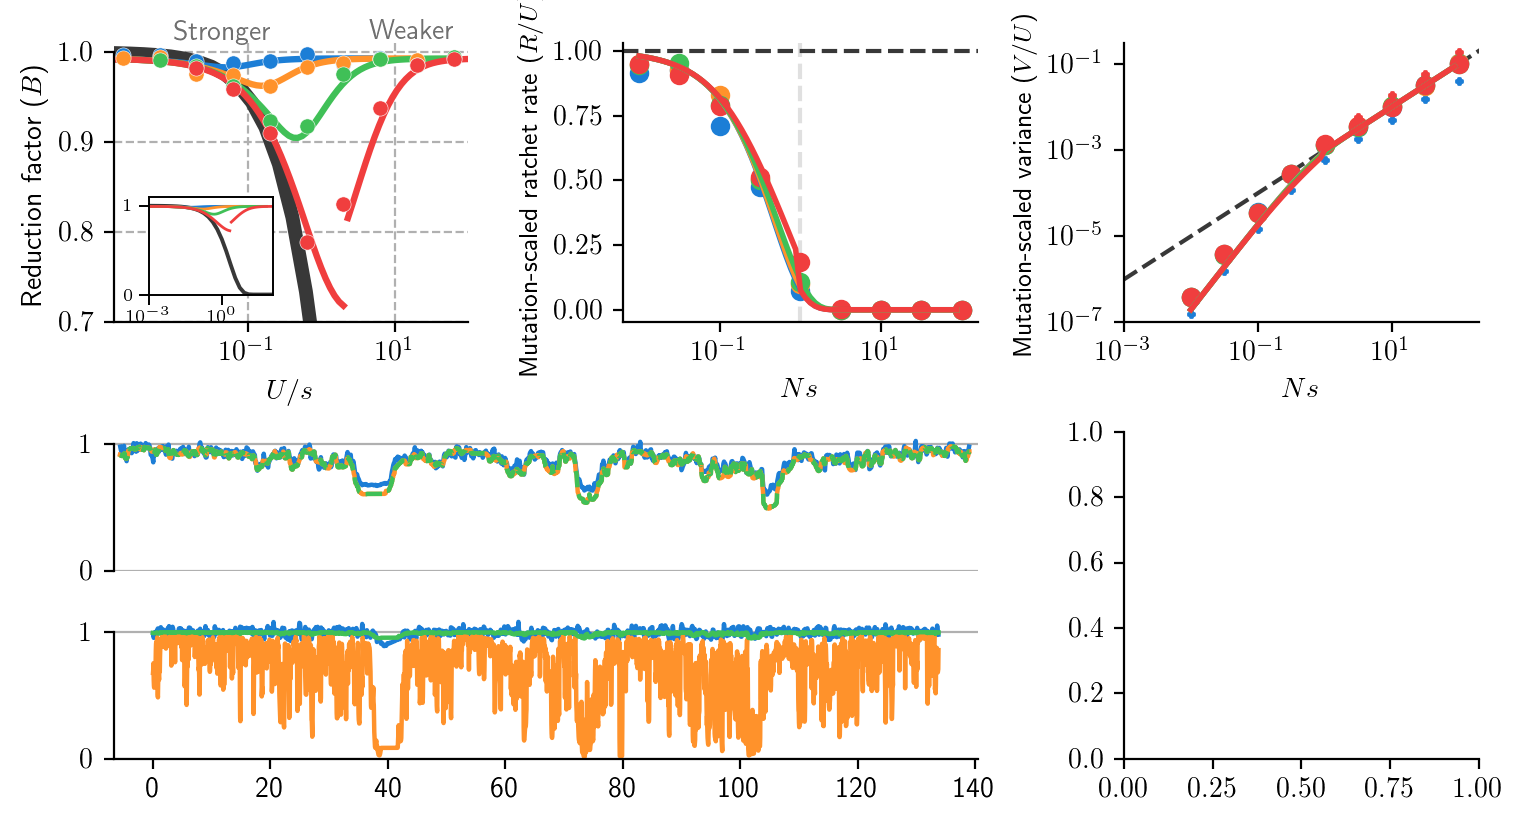

In [118]:
plt.rcParams['text.usetex'] = True
label_fs = 9

fig = plt.figure(constrained_layout=True, figsize=(7.5, 4))

axd = fig.subplot_mosaic(
    """
    ABC
    DDF
    EEF
    """,
    height_ratios=[0.5, 0.25, 0.25], 
    gridspec_kw={
        #"bottom": 0.25,
        #"top": 0.95,
        #"left": 0.1,
        #"right": 0.5,
        "wspace": 0.01,
        "hspace": 0.01,
    }
)

ax = axd['A']

######## SUBFIGURE A
### -----------------------------------------------------------------------------------
axin = ax.inset_axes([0.1, 0.1, 0.35, 0.35])

B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, ax), data=theory_data,
              xlim=(0.0015, 100), include_asymp=False,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.01), 
              marker_size=30, bgs_zorder=1,
              legend=True, bgs_linewidth=5, linewidth=2.3)
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)

for item in ([axin.title, axin.xaxis.label, axin.yaxis.label] +
              axin.get_xticklabels() + axin.get_yticklabels()):
    item.set_fontsize(6)

axin.tick_params(axis="y", direction="out", pad=2)
axin.tick_params(axis="x", direction="out", pad=2)
axin_axeswidth = 0.7
for spine in ['top', 'right', 'left', 'bottom']:
    axin.spines[spine].set_visible(True)
    axin.spines[spine].set_linewidth(axin_axeswidth)
axin.xaxis.set_tick_params(width=axin_axeswidth)
axin.yaxis.set_tick_params(width=axin_axeswidth)
    
# draw the box around zoomed-in region
draw_box = False
if draw_box:
    x, y = ax.axes.get_xlim(), ax.axes.get_ylim()
    zoom = mpl.patches.Rectangle((x[0], y[0]), x[1] - x[0], y[1] - y[0], 
                                 linewidth=0.1, edgecolor='0.22', facecolor='none')
    axin.add_patch(zoom)

#ax.axhline(1, linestyle='dashed', c='0.22', linewidth=1, zorder=-1)
#axin.axhline(1, linestyle='dashed', c='0.22', linewidth=0.5, zorder=-1)

#leg = ax.legend(loc=(0.8, 0.2), fontsize=10, title="mutation rate", framealpha=1, facecolor='white')
frame = leg.get_frame()
frame.set_facecolor('blue')
ax.text(0.01, 1.015, "Stronger", c='0.44', style='italic')
ax.quiver(0.008, 1.02, -0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.text(4.5, 1.015, "Weaker",  c='0.44', style='italic')
ax.quiver(28, 1.02, 0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
# ax.annotate("  Classic\nBGS theory", xy=(0.55, 0.1), xytext=(0.75, 0.05), 
#             backgroundcolor='white', 
#              arrowprops=dict(arrowstyle="-|>", color='0.22', relpos=(0., 0.5),
#                             connectionstyle="arc3,rad=-0.1"),
#             xycoords=ax.transAxes, weight=550)

ax.set_ylabel("Reduction factor ($B$)")
ax.set_xlabel("$U/s$")
ax.spines['left'].set_bounds((0.7, 1))
ax.grid(linestyle='dashed')
ax.set_axisbelow(True)
#axin.annotate("  Classic\nBGS theory", xy=(0.05, 0.1), fontsize=5)
ax.set_yticks([0.7, 0.8, 0.9, 1])

# # mask the grid behind arrows
# mask_grid_quiver = mpl.patches.Rectangle((0, 1.005), 100, 0.1, facecolor='white', zorder=1)
# ax.add_patch(mask_grid_quiver)

# # mask grid behind legend
# mask_grid = mpl.patches.Rectangle((15, 0.2), 400, 0.8, facecolor='white', zorder=1)
# ax.add_patch(mask_grid)


######## SUBFIGURE B

ax = axd['B']

for mu in theory_data.keys():
    if mu == 1e-10:
        continue
    mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
    dgs = dg.loc[dg['mu'] == mu]
    U = 2*mu*L
    s = theory_data[mu][0]
    sN = s*N
    T = theory_data[mu][4]
    R = 2/(T*U)
    col = next(ax._get_lines.prop_cycler)['color']
    keep = sN < 1e2
    ax.plot(N*s[keep], R[keep], c=col, alpha=1, linewidth=2, label=mu_label)
    
    R_est = np.array([rates[(mu, sh)] for sh in dgs['sh']])
    ax.scatter(dgs['sh']*N, 2*R_est/U, c=col)
ax.set_ylabel("Mutation-scaled ratchet rate ($R/U$)", fontsize=label_fs)
#ax.set_ylabel("Mutation-scaled ratchet rate")
ax.set_xlabel("$Ns$")

fig.canvas.draw()
#ax.legend(title="mutation rate")
ax.axhline(1, linestyle='dashed', c='0.22')
#ax.annotate("neutral fixation rate ($R = U$)", (1, 1.01), xycoords='data')
ax.set_xscale('log')
ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')

######## SUBFIGURE C
ax = axd['C']
for mu in theory_data.keys():
    if mu == 1e-10:
        continue
    mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
    U = 2*mu*L
    sN = theory_data[mu][0] * N
    T = theory_data[mu][4]
    V = theory_data[mu][3] / U
    R =  1/T
    
    keep = sN < 1e2
    col = next(ax._get_lines.prop_cycler)['color']
    ax.plot(sN[keep], V[keep], linewidth=2,  label=mu_label, c=col)

    # new theory
    #ax.plot(sN, V, c=lines[0].get_color(), alpha=1, linewidth=2, label=mu_label)
    dgs = dg.loc[dg['mu'] == mu]
    # full fitness, including LD
    VA = dgs['f_sd']**2
    # genic fitness. k_mean is average of COUNT of mutations per diploid individual.
    Vf = dgs['sh']**2 * dgs['k_mean'] / 2
    ax.scatter(dgs['sh'] * N, Vf / (dgs['U']), c=col)
    ax.scatter(dgs['sh'] * N, VA / (dgs['U']), c=col, marker='P', s=4)
xs = np.logspace(-6, -0.5, 100)

ax.plot(xs*N, xs, zorder=-10, linestyle='dashed', c='0.22')
# ax.annotate("strong BGS variance", (2e-3, 4e-6), xycoords='data', rotation=30)
ax.set_ylabel("Mutation-scaled variance ($V/U$)", fontsize=label_fs)
#ax.set_ylabel("Mutation-scaled variance")
ax.set_xlabel("$Ns$")

# ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')
# fig.canvas.draw()
# ax.legend(loc=(-0.04, 0.6), fontsize=10, ncol=2, title="mutation rate")
ax.loglog()
ax.set_xlim(1e-3, 2e2)
ax.set_ylim(1e-7, 3e-1)
# ax.annotate("$Ns = 1$", (1.1, 5e-8), xycoords='data', weight=550)
# ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7),
#             xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>'))
# ax.annotate("fitness variance\nlost due to ratchet", (6e-3, 3e-7), horizontalalignment='center',
#             bbox=dict(facecolor='white', alpha=1, linewidth=0), 
#             fontsize=6, rotation=30)


######## SUBFIGURE D & E

g = sibfigc_data['g']
b = sibfigc_data['b']
bp = sibfigc_data['bp']
sim_means_100kb = sibfigc_data['sim_means_100kb']
sim_sd_100kb = sibfigc_data['sim_sd_100kb']


ax = (axd['D'], axd['E'])


show_sd = False
lwd = 1.6
ticks_x = mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6))

#fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(8, 2))
w, t = 1e-8, 3.16e-3


ax[0].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd)
ax[0].plot(*b['chr10', w, t], label="Classic BGS Theory", linewidth=lwd)
ax[0].plot(*bp['chr10', w, t], label="New Theory", linestyle='dashed', linewidth=lwd)

if show_sd:
    simsd = sim_sd_100kb['chr10', w, t]
    simm = sim_means_100kb['chr10', w, t]
    ax[0].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)

#ax[0].set_ylim(0.5, 1.1)
ax[0].set_ylim(0, 1.1)



ax[0].spines['bottom'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].grid()
ax[0].spines.left.set_bounds((0, 1))
ax[1].xaxis.set_major_formatter(ticks_x)
ax[0].set_xlim(-1000000, 1.01*g.seqlens['chr10'])

#w, t = 3.16e-9, 1e-4
w, t = 1e-8, 1e-4
mb_bins = bin_chroms(g.seqlens, 40e3)

ax[1].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd)
ax[1].plot(*b.bin_means(mb_bins)['chr10', w, t], label="Classic BGS Theory", linewidth=lwd)
ax[1].plot(*bp['chr10', w, t], label="New Theory", linewidth=lwd)

if show_sd:
    simsd = sim_sd_100kb['chr10', w, t]
    simm = sim_means_100kb['chr10', w, t]
    ax[1].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)

ax[1].grid(axis='y')
ax[1].set_ylim(0, 1.1)
ax[1].spines.left.set_bounds((0, 1))


#leg = ax[0].legend(ncol=3, loc=(0.05, -0.3))
# for handle in leg.legendHandles:
#     #handle.set_linewidth(2.0)
#     handle.set_linestyle('solid')

#fig.tight_layout()

# Miscellaenous Checks

Here are some additional visual / EDA checks of theory equations, e.g. $Q$ and a look at how the adjusted $N_e$ differs from the asymptotic $N_e$.

## Validation of $Q$ Equations

There are two classes of equations for $Q$, the selection multiplier. In both cases, $Q^2$ is used in the fomrula.

 - *Regional $Q$*: this is the multiplier effect for a single neutral locus in the middle of a segment. This is used to pre-compute the segment $V$ and $R$.
 
 - *Recombination $Q$*: this is the multiplier effect for a single segment (which is the same as a single site, with $V_m$ and $V$ adjusted accordingly, $r$ recombination fraction away.

Pre-computation of the integrated $Q$ in the main code uses the integral approximation (in code as `Q2_sum_integral()`) so we compare that against alternatives below.

/home/vsb/projects/bprime/bgspy/theory2.py:176: RuntimeWarning: overflow encountered in double_scalars
  (-1 + np.exp(((-(k*(M-2)) + M)*T)/2.))**2)/
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: overflow encountered in double_scalars
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: overflow encountered in exp
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: invalid value encountered in double_scalars
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:175: RuntimeWarning: invalid value encountered in double_scalars
  ((-2*np.exp(k*(M-2)*T - M*T) *
/home/vsb/projects/bprime/bgspy/theory2.py:176: RuntimeWarning: overflow encountered in exp
  (-1 + np.exp(((-(k*(M-2)) + M)*T)/2.))**2)/
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: overflow encountered in expm1
  in

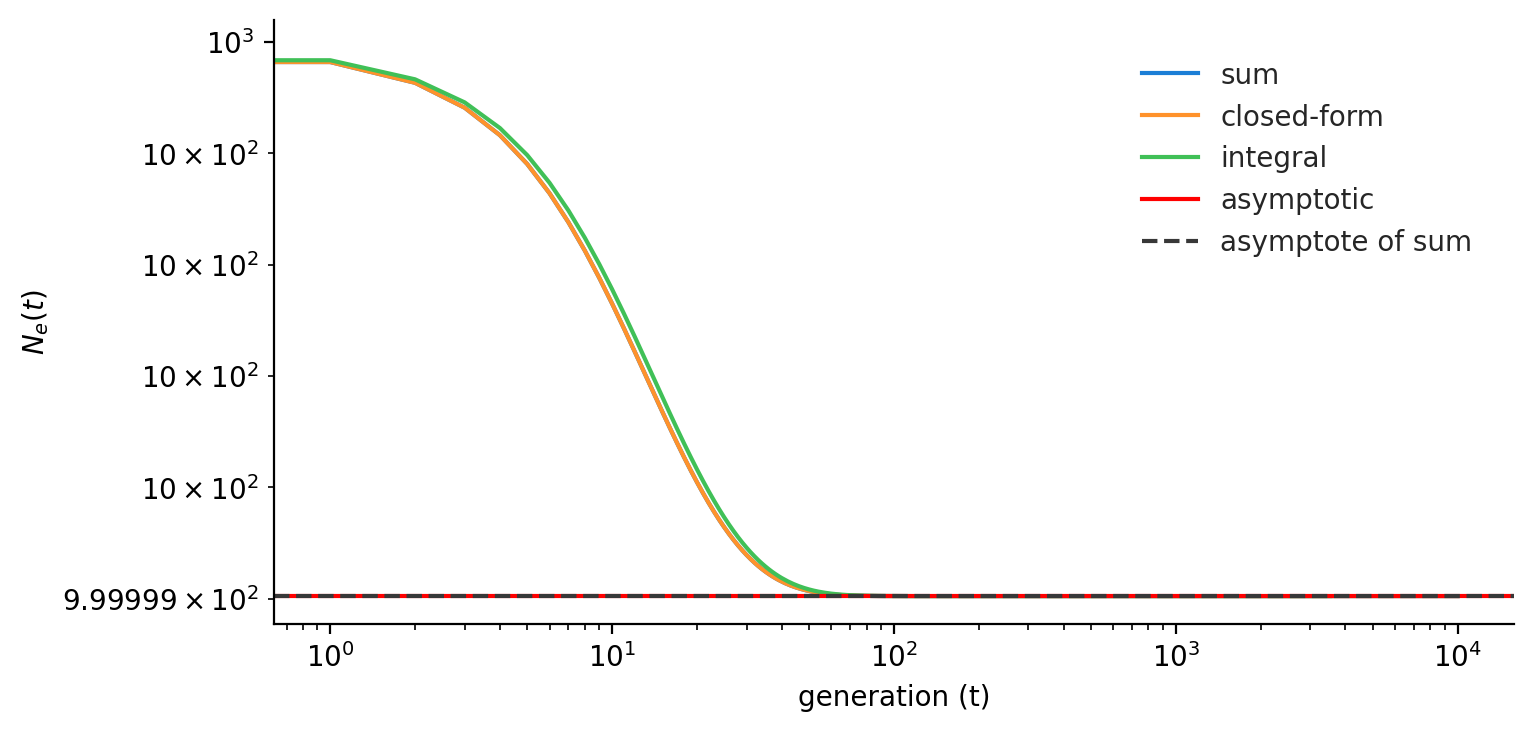

In [39]:
# some test parameters
V = 1e-8
Vm = 0.1*V
R = rbp*L
Z = 1-Vm/V
plt.plot(N*np.exp(-V/2*Q2_sum_integral(Z, R, 10000, use_sum=True)), label='sum')
plt.plot(N*np.exp(-V/2*Q2_sum_integral(Z, R, 10000, use_sum=False)), label='closed-form')
plt.plot(N*np.exp(-V/2*Q2_sum_integral2(Z, R, 10000)), label='integral')
plt.axhline(N*np.exp(-V/2 * Q2_asymptotic(Z, R)), c='r', label='asymptotic')
plt.axhline(N*np.exp(-V/2* Q2_sum_integral(Z, R)[-1]), c='0.22', label='asymptote of sum', linestyle='dashed')
plt.loglog()
plt.ylabel("$N_e(t)$")
plt.xlabel("generation (t)")
plt.legend()

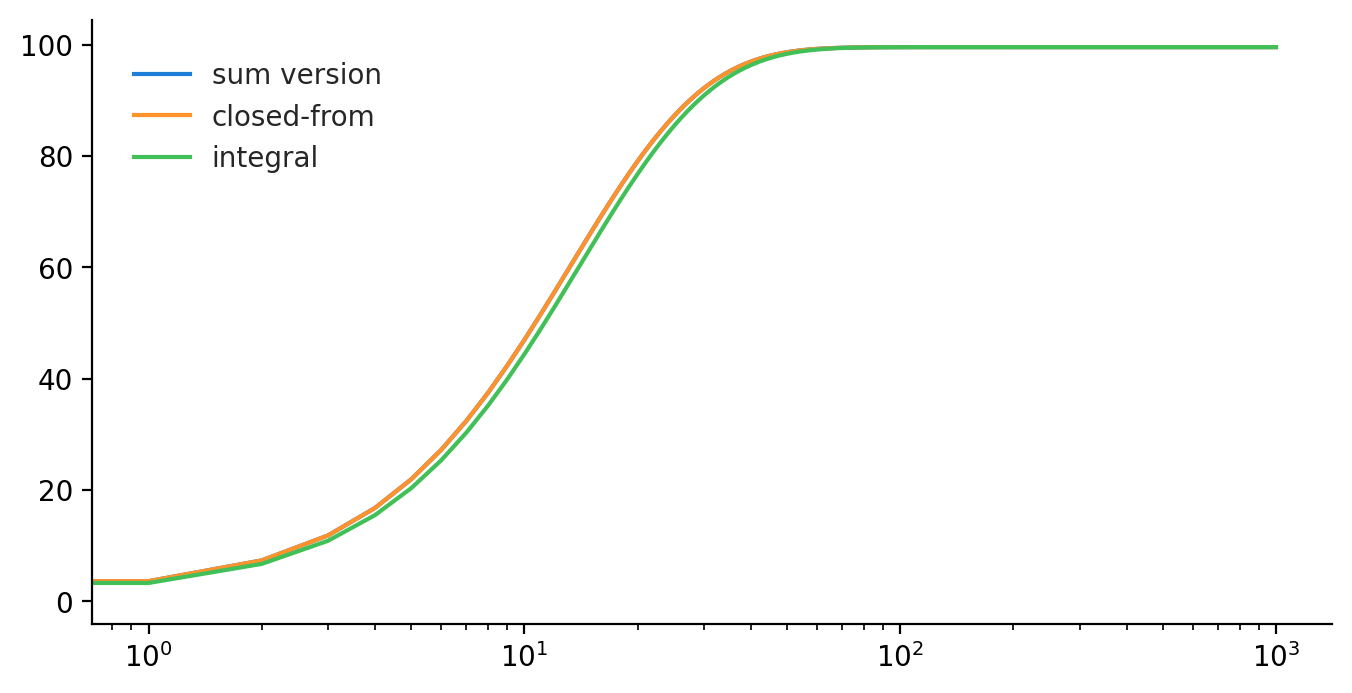

In [40]:
plt.plot(Q2_sum_integral(Z, R, use_sum=True), label='sum version')
plt.plot(Q2_sum_integral(Z, R, use_sum=False), label='closed-from')
plt.plot(Q2_sum_integral2(Z, R), label='integral')
#plt.axline((0, 0), slope=1, c='r', linestyle='dashed')
plt.semilogx()
plt.legend()

## Averaged $N_e$ vs Asymptotic $N_e$ Approximations

We pre-compute the $V$ and $V_m$ for each segment using the regional calculations. Then, we use these $V$ and $V_m$ values in a non-regional equation (just $r$), e.g. 

$$
Q(t) = \sum_{i=0}^t a^i
$$

where $a = (1-r)(1-V_m/V)$. 

Then, $N_e(t) = N \exp(-V/2 Q(t)^2$ and the $B$ estimate is 

$$
2N B = \sum_{t = 0}^\infty \prod_{i=0}^t \left(1- \frac{1}{2N_e(t)}\right)
$$

This sum takes many elements to converge. Ben Good had a [very helpful trick on Twitter](https://twitter.com/benjaminhgood/status/1588531110853881856), which reduced the number of iterations a few orders of magnitude. Still, though, this was too slow to apply each iteration so I use a linear interpolator of the "bias" between the asymptotic $N_{e,\infty}$ and $N_e(t)$.

NOTE: this turned out to matter a lot in the regional simulations (which have a large mutational target size and tight linkage), but very little in the human B maps.

In [41]:
# some example Qs -- should be very close after 100k gens
Qr_fixed(100_000, 1e-8, 1e-9, 1e-3), Qr_asymp(1e-8, 1e-9, 1e-3)

(9.910802775024777, 9.910802775024777)

How does the asymptotic $N_e$ differ from $N_e(t)$?

Note: $Q(t)$ only depends on a compound parameter $a = (1-r)(1-\kappa)$, where $\kappa = V_m/V$. So these can be combined (the functions with this alternate simpler parameteriztion of $V$ and $a$ have names that end in 2.

In [42]:
# some params
a = np.sort(1-np.logspace(-8, -1, 100))
Vs = np.logspace(-10, -7, 4)

Are the C and Python versions of the $N_e(t)$ giving us the same answers?

In [43]:
python = Ne_t_full2(N, Vs.mean(), a)

In [44]:
C = Ne_t(a, Vs.mean(), N)

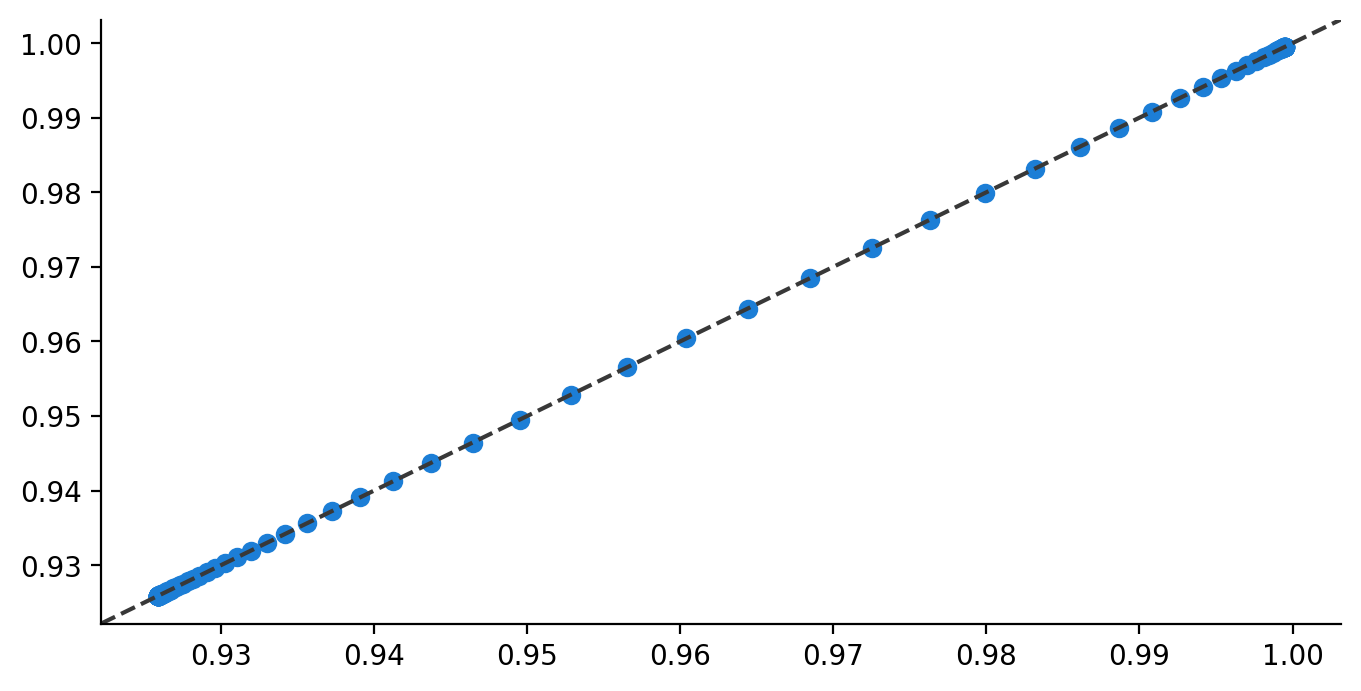

In [45]:
plt.scatter(python/N, C/N)
plt.axline((0.99, 0.99), slope=1, c='0.22', linestyle='dashed')

## Bias caused by using Asymptotic $N_e$

How big is the difference between asymptotic $N_e$ and $N_e(t)$? It causes a sort of bias, which we estimate below.

In [26]:
# a simple grid of test parameter values values
grid = np.meshgrid(a, Vs)

In [27]:
asymp = Ne_asymp2(*grid, N)/N
real = Ne_t(*grid, N)/N
bias = asymp - real 

How does B differ when asymptotic vs adjusted $N_e$ is used?

[]

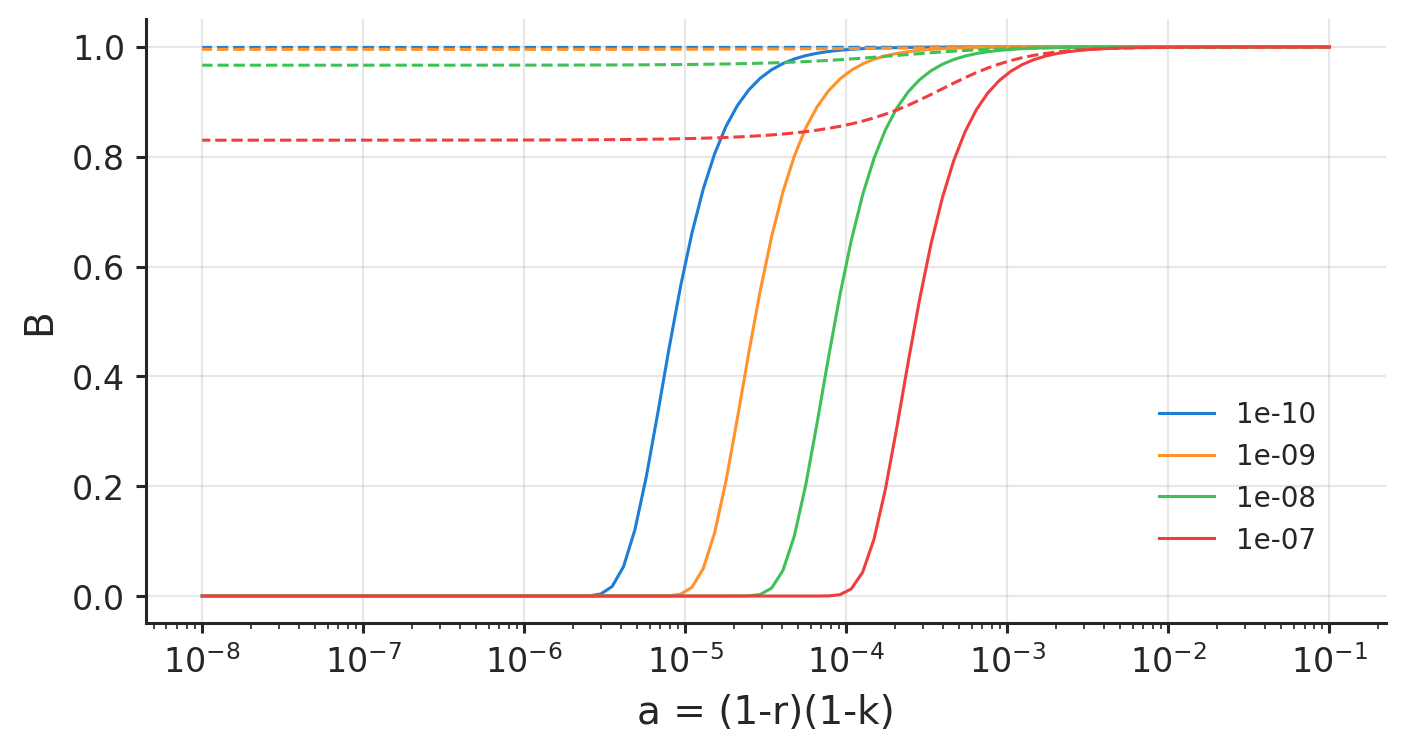

In [28]:
plt.plot(1-a, asymp.T, label=Vs)
plt.gca().set_prop_cycle(None)
plt.plot(1-a, real.T,  linestyle='dashed')
plt.grid()
plt.ylabel("B")
plt.xlabel("a = (1-r)(1-k)")
plt.legend()
plt.semilogx()

This shows why the B maps don't really need the adjusted $N_e$ — the bias is small except for very tiny a values.

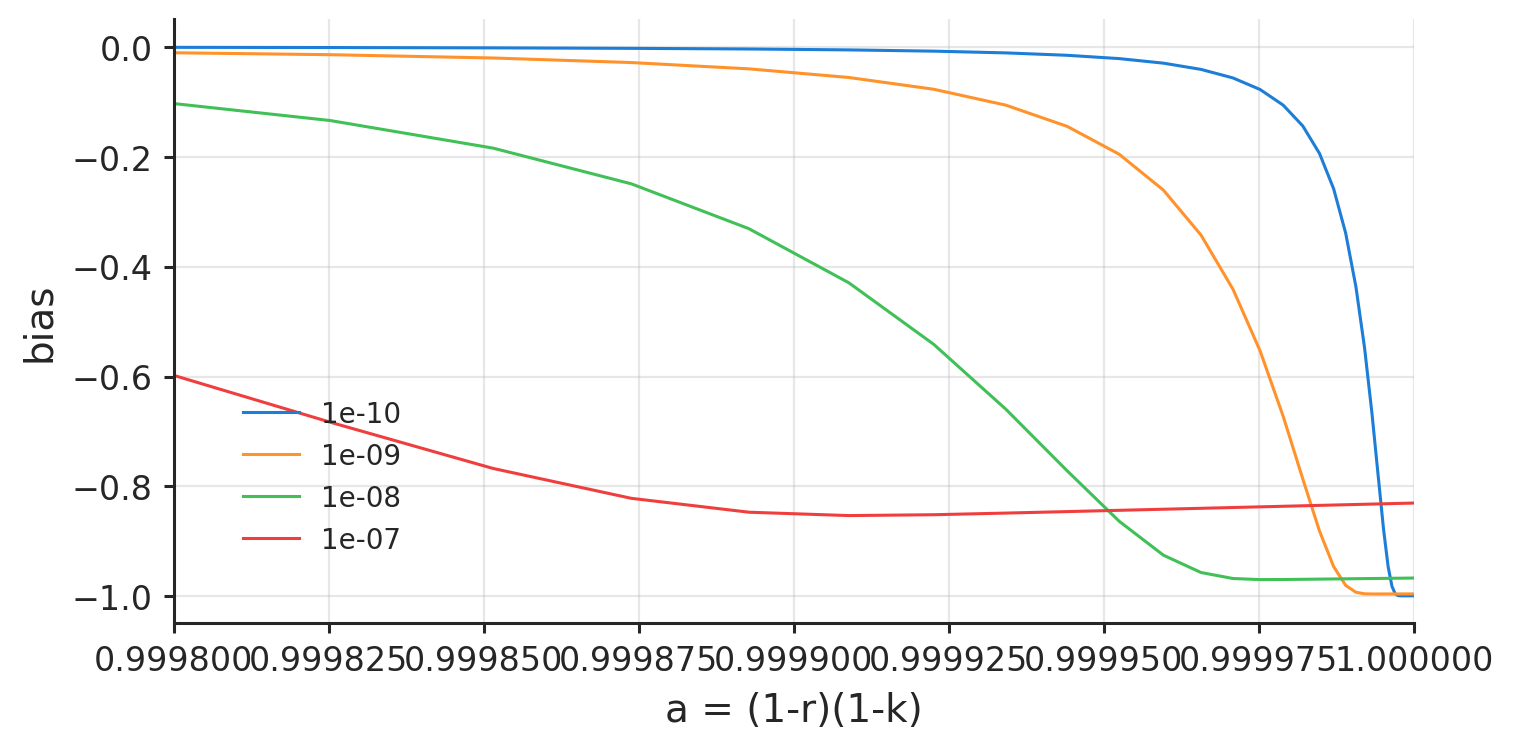

In [29]:
plt.plot(a, bias.T, label=Vs)
plt.ylabel("bias")
plt.xlabel("a = (1-r)(1-k)")
plt.legend()
plt.xlim(0.9998, 1)
plt.grid()

Note the bias is really only in the region of $a = 1-\varepsilon$ as $\varepsilon \to \infty$. This is the tight linkage / HRI region.

### Bias Interpolator 

The adjusted $N_e$ sum is incredibly slow to calculate, even with tricks, and even when implemented in C. To test whether the B maps are impacted by this, I used a grid interpolator for the bias.

Let's build an bias interpolator. There are two options in scipy, `interpn()` and `RegularGridInterpolator()`

NOTE: As mentioned elsewhere, it made little difference; the code is now commented out in the library.

In [36]:
# big grid
n = 50
a_grid = np.sort(1-np.logspace(-8, -3, n))
V_grid = np.logspace(-10, -7, n)
interp_grid = np.meshgrid(a_grid, V_grid)

In [37]:
interp_asymp = Ne_asymp2(*interp_grid, N)/N
interp_real = Ne_t(*interp_grid, N)/N
interp_bias = interp_asymp - interp_real 

In [38]:
a_grid.min(), a_grid.max()

(0.999, 0.99999999)

In [39]:
Ne_asymp2(0.9999997404975789, 1e-10, 1000)

array(0)

In [43]:
fun = RegularGridInterpolator((a_grid, V_grid), np.log10(-interp_bias).T, method='linear')

/tmp/ipykernel_20961/2484665850.py:1: RuntimeWarning: invalid value encountered in log10
  fun = RegularGridInterpolator((a_grid, V_grid), np.log10(-interp_bias).T, method='linear')


In [44]:
%%timeit

ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='splinef2d')

267 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [45]:
%%timeit

ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
fun((ra, rV))

121 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
%%timeit

ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
fun((ra, rV))

122 µs ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [47]:
linear = []
spline = []
reggrid = []
for i in range(1000):
    ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
    linear.append(interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='linear'))
    spline.append(interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='splinef2d'))
    reggrid.append(10**fun((ra, rV)))

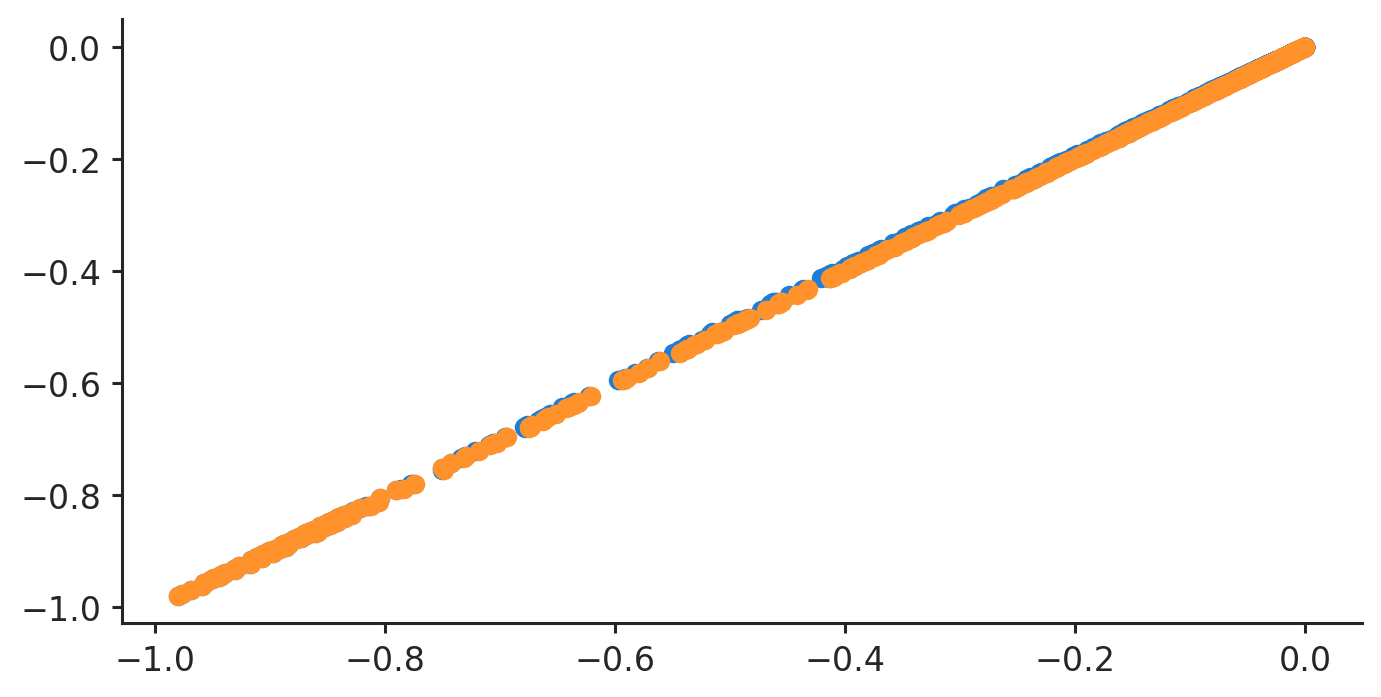

In [48]:
plt.scatter(linear, spline)
plt.scatter(-np.array(reggrid), spline)

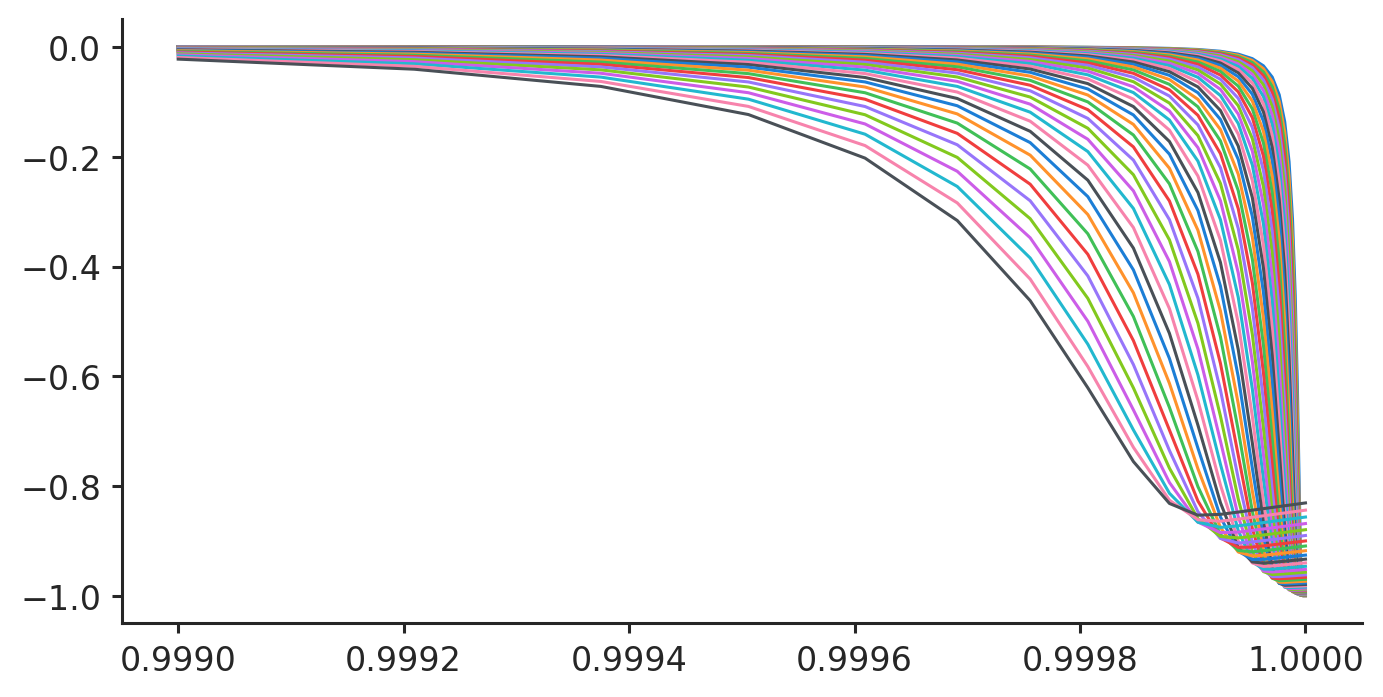

In [49]:
_ =plt.plot(a_grid, interp_bias.T,)